# Topology weight plots across methods

In [1]:
library(tidyverse)
library(data.table)
library(foreach)
library(progress)
library(hexbin)
library(patchwork)
library(gridExtra)

options(scipen=999)

plot_theme <- theme_bw() + theme(panel.grid = element_blank())

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when



Attaching package: ‘gridExtra’

## Functions

In [2]:
# -----
loess.smooth.weights = function(pos, topoWeights, sites, span, family){
    y.loess <- loess(topoWeights ~ pos, span = span, weights = sites, family=family)
    y.predict <- predict(y.loess, pos)
    y.predict
}

## Read data

In [18]:
## For future: just read this file
wt = fread('~/snap_hap_repHZ/twisst/comparison/Flavia.comparison.tsv.gz')
str(wt)

Classes ‘data.table’ and 'data.frame':	461864 obs. of  15 variables:
 $ snpID   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ scaffold: chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ pos     : int  45000962 45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 ...
 $ wt1_nj  : num  0.379 0.379 0.379 0.379 0.379 ...
 $ wt2_nj  : num  0.318 0.318 0.318 0.318 0.318 ...
 $ wt3_nj  : num  0.303 0.303 0.303 0.303 0.303 ...
 $ wt1_ts  : num  0.347 0.339 0.347 0.378 0.308 ...
 $ wt2_ts  : num  0.282 0.284 0.273 0.271 0.302 ...
 $ wt3_ts  : num  0.271 0.277 0.281 0.262 0.249 ...
 $ wt1_rel : num  0.374 0.374 0.374 0.359 0.349 ...
 $ wt2_rel : num  0.303 0.303 0.303 0.324 0.35 ...
 $ wt3_rel : num  0.323 0.323 0.323 0.317 0.301 ...
 $ wt1_sg  : num  0.345 0.339 0.341 0.328 0.321 ...
 $ wt2_sg  : num  0.343 0.337 0.335 0.34 0.354 ...
 $ wt3_sg  : num  0.312 0.324 0.325 0.333 0.325 ...
 - attr(*, ".internal.selfref")=<externalptr> 


### _Neighbor joining_

In [3]:
# 50SNP windows
# -----
pos = fread('~/snap_hap_repHZ/twisst/trees_phyml/Chr2.AvePla.stitch.SnpOnly.final.region45-65Mb.w50.data.tsv')
weights = fread('~/snap_hap_repHZ/twisst/trees_phyml/Chr2.AvePla.stitch.SnpOnly.final.region45-65Mb.w50.twisst')
nj = cbind(pos, weights)
nj = nj %>% mutate(span = end - start,
                   total = topo1+topo2+topo3,
                   wt1 = topo1/total, 
                   wt2 = topo2/total, 
                   wt3 = topo3/total)

# Smoothing
span_bp = 50000; chromLength = 77118269; span = span_bp/chromLength
nj$wt1.smooth = loess.smooth.weights(nj$mid, nj$wt1, nj$sites, span=span, "gaussian")
nj$wt2.smooth = loess.smooth.weights(nj$mid, nj$wt2, nj$sites, span=span, "gaussian")
nj$wt3.smooth = loess.smooth.weights(nj$mid, nj$wt3, nj$sites, span=span, "gaussian")

# Order columns
column_order = c('scaffold', 'start', 'end', 'mid', 'span', 
                 'sites', 'topo1', 'topo2', 'topo3', 'total',
                 'wt1', 'wt2', 'wt3',
                 'wt1.smooth', 'wt2.smooth', 'wt3.smooth')
nj = nj[, ..column_order]

fwrite(nj, '~/snap_hap_repHZ/twisst/comparison/Flavia.nj.weights.tsv', sep='\t', quote=F, col.names=T, row.names=F)
str(nj)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“k-d tree limited by memory. ncmax= 9237”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“k-d tree limited by memory. ncmax= 9237”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“k-d tree limited by memory. ncmax= 9237”


Classes ‘data.table’ and 'data.frame':	9237 obs. of  16 variables:
 $ scaffold  : chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ start     : int  45000962 45004205 45005709 45007645 45008885 45013159 45014181 45015463 45018137 45020213 ...
 $ end       : int  45004199 45005581 45007614 45008863 45013157 45014179 45015450 45018072 45020066 45024082 ...
 $ mid       : int  45002971 45004849 45006756 45008136 45011306 45013654 45014697 45016597 45019048 45022162 ...
 $ span      : int  3237 1376 1905 1218 4272 1020 1269 2609 1929 3869 ...
 $ sites     : int  50 50 50 50 50 50 50 50 50 50 ...
 $ topo1     : int  3786 4675 3666 5343 4316 3361 3660 3732 5250 4643 ...
 $ topo2     : int  3179 2629 3152 2182 2823 3316 3173 3319 2339 2656 ...
 $ topo3     : int  3035 2696 3182 2475 2861 3323 3167 2949 2411 2701 ...
 $ total     : int  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 ...
 $ wt1       : num  0.379 0.468 0.367 0.534 0.432 ...
 $ wt2       : num  0.318 0.263 0.315 0.218 0.282 .

In [4]:
sum(nj$sites)
mean(nj$span, na.rm=T)
sd(nj$span, na.rm=T)

[1] 461850

[1] 2126.441

[1] 2250.413

### _Relate_

In [5]:
# Relate
# -----
rel = fread('~/snap_hap_repHZ/twisst/trees_relate/weights/chr2.weights.smooth.csv.gz')
rel = rel[start >= 45000000 & start <= 65000000]
rel$span = rel$end - rel$start
rel$scaffold = rep('Chr2', nrow(rel))

# Order columns
column_order = c('scaffold', 'start', 'end', 'mid', 'span', 
                 'sites', 'topo1', 'topo2', 'topo3', 'total',
                 'wt1', 'wt2', 'wt3',
                 'wt1.smooth', 'wt2.smooth', 'wt3.smooth')
rel = rel[, ..column_order]

# fwrite(rel, '~/snap_hap_repHZ/twisst/comparison/Flavia.relate.weights.tsv.gz', sep='\t', quote=F, col.names=T, row.names=F)
str(rel)

Classes ‘data.table’ and 'data.frame':	198375 obs. of  16 variables:
 $ scaffold  : chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ start     : int  45000962 45001402 45001426 45002205 45002446 45002477 45002489 45002505 45002759 45002775 ...
 $ end       : int  45001401 45001425 45002204 45002445 45002476 45002488 45002504 45002758 45002774 45002807 ...
 $ mid       : num  45001182 45001414 45001815 45002325 45002461 ...
 $ span      : int  439 23 778 240 30 11 15 253 15 32 ...
 $ sites     : int  3 1 2 1 2 2 1 4 1 3 ...
 $ topo1     : int  3738 3588 3492 3759 3604 3709 4037 3834 4178 4017 ...
 $ topo2     : int  3030 3243 3498 3264 3341 3190 2815 3132 2877 2753 ...
 $ topo3     : int  3232 3169 3010 2977 3055 3101 3148 3034 2945 3230 ...
 $ total     : int  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 ...
 $ wt1       : num  0.374 0.359 0.349 0.376 0.36 ...
 $ wt2       : num  0.303 0.324 0.35 0.326 0.334 ...
 $ wt3       : num  0.323 0.317 0.301 0.298 0.305 ...
 $ wt1.smooth:

In [5]:
mean(rel$span)
sd(rel$span)

sum(rel$sites)
mean(rel$sites)
sd(rel$sites)

[1] 99.81433

[1] 322.405

[1] 461864

[1] 2.328237

[1] 1.663606

### _tsinfer_

In [6]:
tsSites = fread('~/snap_hap_repHZ/tsinfer//newickTreeList//tsD.Chr2.AvePla.FrYe.newick.tsv.gz')
# ts = ts[start >= 45000000 & start <= 65000000]
str(tsSites)

Classes ‘data.table’ and 'data.frame':	1573167 obs. of  5 variables:
 $ treeStart: num  3042 3080 3124 3205 3223 ...
 $ treeEnd  : num  3080 3124 3205 3223 3234 ...
 $ treeSpan : num  38 44 81 18 11 ...
 $ tree     : chr  "(n6:1.00004627915586819,n7:1.00004627915586819,n75:1.00004627915586819,n87:1.00004627915586819,n89:1.0000462791"| __truncated__ "(n6:1.00004627915586819,n7:1.00004627915586819,n75:1.00004627915586819,n87:1.00004627915586819,n89:1.0000462791"| __truncated__ "(n6:1.00004627915586819,n7:1.00004627915586819,n75:1.00004627915586819,n89:1.00004627915586819,(n34:0.013513513"| __truncated__ "((n48:0.01351351328068287,n117:0.01351351328068287):0.98653276587518535,(n34:0.01351351351351351,n35:0.01351351"| __truncated__ ...
 $ sites    : int  2 2 3 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
tsSites = tsSites[treeStart >= 45000000 & treeStart <= 65000000][,c(1:3,5)]
str(tsSites)

Classes ‘data.table’ and 'data.frame':	406135 obs. of  4 variables:
 $ treeStart: num  45000962 45001093 45001227 45001402 45001426 ...
 $ treeEnd  : num  45001093 45001227 45001402 45001426 45001878 ...
 $ treeSpan : num  131 134 175 24 452 327 241 8 23 10 ...
 $ sites    : int  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
# Tsinfer
# -----
ts = fread('~/snap_hap_repHZ/twisst/trees_tskit/twisst_weights_combined/twisst2.csv.gz')
ts = ts[start >= 45000000 & start <= 65000000]

span_bp = 50000; chromLength = 77118269; span = span_bp/chromLength
ts$span = ts$end - ts$start
ts$sites = tsSites$sites
ts$wt1.smooth = loess.smooth.weights(ts$mid, ts$wt1, ts$sites, span=span, "gaussian")
ts$wt2.smooth = loess.smooth.weights(ts$mid, ts$wt2, ts$sites, span=span, "gaussian")
ts$wt3.smooth = loess.smooth.weights(ts$mid, ts$wt3, ts$sites, span=span, "gaussian")

# Order columns
column_order = c('scaffold', 'start', 'end', 'mid', 'span', 
                 'sites', 'topo1', 'topo2', 'topo3', 'total',
                 'wt1', 'wt2', 'wt3',
                 'wt1.smooth', 'wt2.smooth', 'wt3.smooth')
ts = ts[, ..column_order]

# fwrite(ts, '~/snap_hap_repHZ/twisst/comparison/Flavia.tsinfer.weights.tsv.gz', sep='\t', quote=F, col.names=T, row.names=F)
str(ts)

Classes ‘data.table’ and 'data.frame':	406135 obs. of  16 variables:
 $ scaffold  : chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ start     : int  45000962 45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 ...
 $ end       : int  45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 45002487 ...
 $ mid       : num  45001028 45001160 45001314 45001414 45001652 ...
 $ span      : int  131 134 175 24 452 327 241 8 23 10 ...
 $ sites     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ topo1     : int  3471 3392 3467 3777 3076 3722 3728 3491 3639 3693 ...
 $ topo2     : int  2819 2838 2733 2708 3016 2835 2888 2781 2681 2685 ...
 $ topo3     : int  2708 2772 2815 2617 2489 2637 2565 2700 2522 2515 ...
 $ total     : int  8998 9002 9015 9102 8581 9194 9181 8972 8842 8893 ...
 $ wt1       : num  0.347 0.339 0.347 0.378 0.308 ...
 $ wt2       : num  0.282 0.284 0.273 0.271 0.302 ...
 $ wt3       : num  0.271 0.277 0.281 0.262 0.249 ...
 $ wt1.smooth: num  0

In [10]:
# mean(ts$span)
mean(ts$sites)
sd(ts$sites)
sum(ts$sites)

mean(ts$span)
sd(ts$span)

[1] 1.137218

[1] 0.4771877

[1] 461864

[1] 49.24235

[1] 222.2816

### *Singer*

In [11]:
# singer
# -----
sg = data.table()

for (windowID in 0:39){

    ## Get windowStart
    windowSize = 500000
    windowStart = 45000001 + windowID*windowSize
    cat(windowID, '\t', windowStart, '\n')

    ## Read & modify treePos file
    pattern = paste0('~/snap_hap_repHZ/twisst/trees_sg/trees/Chr2.win', windowID, '.*.newick.tsv.gz')
    treePosFile = Sys.glob(pattern)
    treePos = fread(treePosFile)
    treePos = treePos[, 1:3]
    treePos$treeStart = round(treePos$treeStart) + windowStart
    treePos$treeEnd = round(treePos$treeEnd) + windowStart - 1
    treePos$treeSpan = treePos$treeEnd - treePos$treeStart
    colnames(treePos) = c('start', 'end', 'span')
    
    ## Read SNP positions
    SnpPos = fread("~/snap_hap_repHZ/singer/input/Flavia.geno.gz")
    SnpPos = SnpPos[,2]

    ## Calculate sites per tree    
    setkey(treePos, start, end)
    treePos[, sites := SnpPos[treePos, .N, by = .EACHI, on = .(POS >= start, POS <= end)]$N]

    ## Read twisst topo raw and calculate weights
    pattern = paste0('~/snap_hap_repHZ/twisst/trees_sg/weights/', windowID, '.weights.csv.gz')
    topoFile = Sys.glob(pattern)
    topo = fread(topoFile)
    topo = topo %>% mutate(total = topo1+topo2+topo3, 
                           wt1 = topo1/total, 
                           wt2 = topo2/total, 
                           wt3 = topo3/total)    
    
    if(nrow(topo) != nrow(treePos)){cat('Error'); break}

    ## combine files and add to full sg object
    dat = cbind(treePos, topo)
    sg = rbind(sg, dat)
}

# Smoothing
span_bp = 50000; chromLength = 77118269; span = span_bp/chromLength
sg$scaffold = rep('Chr2', nrow(sg))
sg$mid = (sg$start + sg$end)/2
sg$wt1.smooth = loess.smooth.weights(sg$mid, sg$wt1, sg$sites, span=span, "gaussian")
sg$wt2.smooth = loess.smooth.weights(sg$mid, sg$wt2, sg$sites, span=span, "gaussian")
sg$wt3.smooth = loess.smooth.weights(sg$mid, sg$wt3, sg$sites, span=span, "gaussian")


# Order columns
column_order = c('scaffold', 'start', 'end', 'mid', 'span', 
                 'sites', 'topo1', 'topo2', 'topo3', 'total',
                 'wt1', 'wt2', 'wt3',
                 'wt1.smooth', 'wt2.smooth', 'wt3.smooth')
sg = sg[, ..column_order]

# fwrite(sg, '~/snap_hap_repHZ/twisst/comparison/Flavia.singer.weights.tsv.gz', sep='\t', quote=F, col.names=T, row.names=F)

0 	 45000001 
1 	 45500001 
2 	 46000001 
3 	 46500001 
4 	 47000001 
5 	 47500001 
6 	 48000001 
7 	 48500001 
8 	 49000001 
9 	 49500001 
10 	 50000001 
11 	 50500001 
12 	 51000001 
13 	 51500001 
14 	 52000001 
15 	 52500001 
16 	 53000001 
17 	 53500001 
18 	 54000001 
19 	 54500001 
20 	 55000001 
21 	 55500001 
22 	 56000001 
23 	 56500001 
24 	 57000001 
25 	 57500001 
26 	 58000001 
27 	 58500001 
28 	 59000001 
29 	 59500001 
30 	 60000001 
31 	 60500001 
32 	 61000001 
33 	 61500001 
34 	 62000001 
35 	 62500001 
36 	 63000001 
37 	 63500001 
38 	 64000001 
39 	 64500001 


In [12]:
str(sg)

Classes ‘data.table’ and 'data.frame':	1950778 obs. of  16 variables:
 $ scaffold  : chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ start     : num  45000157 45000159 45000356 45000510 45000542 ...
 $ end       : num  45000158 45000355 45000509 45000541 45000604 ...
 $ mid       : num  45000158 45000257 45000432 45000526 45000573 ...
 $ span      : num  1 196 153 31 62 229 59 62 43 48 ...
 $ sites     : int  0 0 0 0 0 0 0 0 1 0 ...
 $ topo1     : int  3307 3397 3310 3424 3428 3351 3464 3435 3447 3276 ...
 $ topo2     : int  3539 3433 3558 3426 3408 3468 3318 3365 3431 3457 ...
 $ topo3     : int  3154 3170 3132 3150 3164 3181 3218 3200 3122 3267 ...
 $ total     : int  10000 10000 10000 10000 10000 10000 10000 10000 10000 10000 ...
 $ wt1       : num  0.331 0.34 0.331 0.342 0.343 ...
 $ wt2       : num  0.354 0.343 0.356 0.343 0.341 ...
 $ wt3       : num  0.315 0.317 0.313 0.315 0.316 ...
 $ wt1.smooth: num  0.347 0.347 0.349 0.349 0.35 ...
 $ wt2.smooth: num  0.342 0.341 0.339 0.338 0.337 .

In [13]:
mean(sg$span)
sd(sg$span)

sum(sg$sites)
mean(sg$sites)
sd(sg$sites)

[1] 9.251414

[1] 24.02561

[1] 461846

[1] 0.2367496

[1] 0.5434857

In [14]:
sum(sg$sites == 0)
sum(sg$sites != 0)
sum(sg$sites == 0) + sum(sg$sites != 0)
sum(sg$sites == 0)/nrow(sg)

[1] 1575011

[1] 375767

[1] 1950778

[1] 0.8073758

### SNP positions

In [15]:
posFile = fread('~/snap_hap_repHZ/twisst/Flavia.pos', header=T)
colnames(posFile) = c('CHROM', 'POS')
str(posFile)

Classes ‘data.table’ and 'data.frame':	461864 obs. of  2 variables:
 $ CHROM: chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ POS  : int  45000962 45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 ...
 - attr(*, ".internal.selfref")=<externalptr> 


### Correlations

In [16]:
posFile_short = posFile[POS>45000000 & POS<59000000]
str(posFile_short)

Classes ‘data.table’ and 'data.frame':	300582 obs. of  2 variables:
 $ CHROM: chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ POS  : int  45000962 45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [17]:
weights = data.table()
colsToKeep = c('wt1', 'wt2', 'wt3')
scaffold = 'Chr2'

pb <- txtProgressBar(min = 0, max = nrow(posFile), style = 3)
# for(posID in 1:100){
for(posID in 1:nrow(posFile)){
    pos = posFile$POS[posID]

    weights_nj = nj[pos>=start & pos<=end][,..colsToKeep]
    weights_ts = ts[pos>=start & pos<end][,..colsToKeep]
    weights_rel = rel[pos>=start & pos<=end][,..colsToKeep]
    weights_sg = sg[pos>=start & pos<=end][,..colsToKeep]

    tmp = cbind(posID, scaffold, pos, weights_nj, weights_ts, weights_rel, weights_sg)
    weights = rbind(weights, tmp, fill=TRUE)
    
    setTxtProgressBar(pb, posID)
}

colnames(weights) = c('snpID', 'scaffold', 'pos',
                     'wt1_nj', 'wt2_nj', 'wt3_nj', 
                     'wt1_ts', 'wt2_ts', 'wt3_ts', 
                     'wt1_rel', 'wt2_rel', 'wt3_rel', 
                     'wt1_sg', 'wt2_sg', 'wt3_sg')

close(pb)

  |==============================                                        |  42%

In [43]:
## Fix weights
# a = weights[461865:nrow(weights),c(16,2,3,17:28)]
# colnames(a) = c('snpID', 'scaffold', 'pos',
#                      'wt1_nj', 'wt2_nj', 'wt3_nj', 
#                      'wt1_ts', 'wt2_ts', 'wt3_ts', 
#                      'wt1_rel', 'wt2_rel', 'wt3_rel', 
#                      'wt1_sg', 'wt2_sg', 'wt3_sg')

In [44]:
# fwrite(weights, file = '~/snap_hap_repHZ/twisst/comparison/Flavia.comparison.tsv.gz', sep='\t', row.names=F, quote=F)
wt = fread('~/snap_hap_repHZ/twisst/comparison/Flavia.comparison.tsv.gz')
str(wt)

Classes ‘data.table’ and 'data.frame':	461864 obs. of  15 variables:
 $ snpID   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ scaffold: chr  "Chr2" "Chr2" "Chr2" "Chr2" ...
 $ pos     : int  45000962 45001093 45001227 45001402 45001426 45001878 45002205 45002446 45002454 45002477 ...
 $ wt1_nj  : num  0.379 0.379 0.379 0.379 0.379 ...
 $ wt2_nj  : num  0.318 0.318 0.318 0.318 0.318 ...
 $ wt3_nj  : num  0.303 0.303 0.303 0.303 0.303 ...
 $ wt1_ts  : num  0.347 0.339 0.347 0.378 0.308 ...
 $ wt2_ts  : num  0.282 0.284 0.273 0.271 0.302 ...
 $ wt3_ts  : num  0.271 0.277 0.281 0.262 0.249 ...
 $ wt1_rel : num  0.374 0.374 0.374 0.359 0.349 ...
 $ wt2_rel : num  0.303 0.303 0.303 0.324 0.35 ...
 $ wt3_rel : num  0.323 0.323 0.323 0.317 0.301 ...
 $ wt1_sg  : num  0.345 0.339 0.341 0.328 0.321 ...
 $ wt2_sg  : num  0.343 0.337 0.335 0.34 0.354 ...
 $ wt3_sg  : num  0.312 0.324 0.325 0.333 0.325 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Correlations

In [19]:
cor(wt[,c(4,7,10,13)], use='na.or.complete', method='spearman')
cor(wt[,c(5,8,11,14)], use='na.or.complete', method='spearman')
cor(wt[,c(6,9,12,15)], use='na.or.complete', method='spearman')

,wt1_nj,wt1_ts,wt1_rel,wt1_sg
wt1_nj,1.0000000,0.5719756,0.6505219,0.5921882
wt1_ts,0.5719756,1.0000000,0.7156536,0.6742945
wt1_rel,0.6505219,0.7156536,1.0000000,0.7704441
wt1_sg,0.5921882,0.6742945,0.7704441,1.0000000


,wt2_nj,wt2_ts,wt2_rel,wt2_sg
wt2_nj,1.0000000,0.5051944,0.5957431,0.5280120
wt2_ts,0.5051944,1.0000000,0.6591736,0.6062085
wt2_rel,0.5957431,0.6591736,1.0000000,0.7265167
wt2_sg,0.5280120,0.6062085,0.7265167,1.0000000


,wt3_nj,wt3_ts,wt3_rel,wt3_sg
wt3_nj,1.0000000,0.4525385,0.5586009,0.5025179
wt3_ts,0.4525385,1.0000000,0.6185606,0.5743377
wt3_rel,0.5586009,0.6185606,1.0000000,0.7079720
wt3_sg,0.5025179,0.5743377,0.7079720,1.0000000


In [120]:
biplot_weights = function(data, x, y, Limits){
    colorRange = c(1,1000)
    plot_theme <- theme_bw() + theme(panel.grid = element_blank(), 
                                     axis.text = element_text(size=8), 
                                     axis.title = element_text(size=8), 
                                     legend.text=element_text(size=5),
                                     legend.title=element_text(size=8),
                                     legend.position=c(0.15,0.7),
                                    )
    
    ggplot(data, aes(x=.data[[x]], y=.data[[y]])) + 
            # geom_hex(bins=75) + 
            geom_bin_2d(bins=200) +
            scale_x_continuous(limits=Limits, expand=c(0,0)) + 
            scale_y_continuous(limits=Limits, expand=c(0,0)) + 
            scale_fill_viridis_c(option='D', limits=colorRange, oob = scales::squish) +
            geom_abline(slope = 1, intercept = 0) +
            plot_theme
}

Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 32 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”


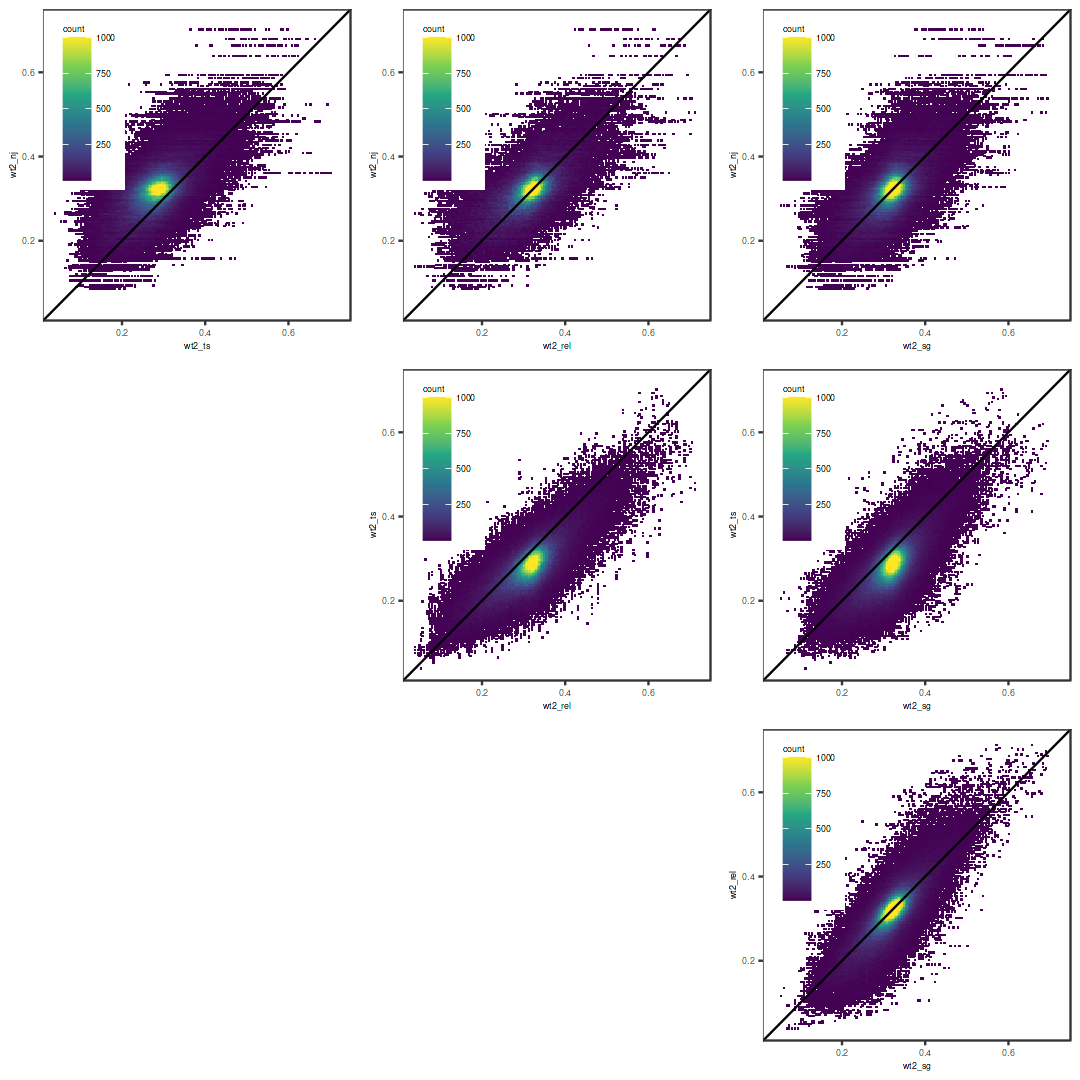

In [115]:
options(repr.plot.width=9, repr.plot.height=9)
grid.arrange(biplot_weights(wt, "wt2_ts", "wt2_nj", c(0.01,0.75)),
             biplot_weights(wt, "wt2_rel", "wt2_nj", c(0.01,0.75)), 
             biplot_weights(wt, "wt2_sg", "wt2_nj", c(0.01,0.75)),

             blank_plot, 
             biplot_weights(wt, "wt2_rel", "wt2_ts", c(0.01,0.75)),
             biplot_weights(wt, "wt2_sg", "wt2_ts", c(0.01,0.75)),

             blank_plot,
             blank_plot,
             biplot_weights(wt, "wt2_sg", "wt2_rel", c(0.01,0.75)))

Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 32 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”


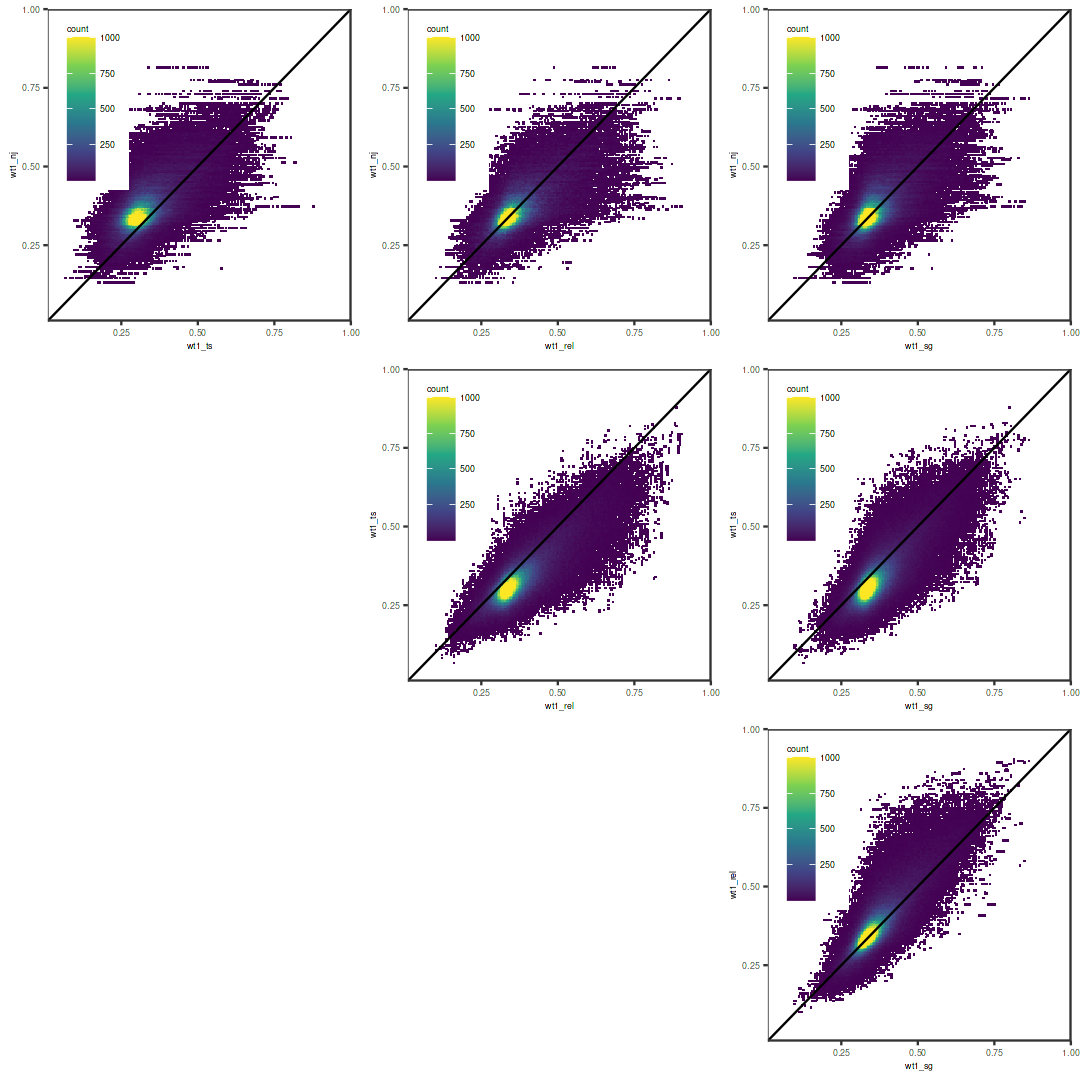

In [116]:
options(repr.plot.width=9, repr.plot.height=9)
grid.arrange(biplot_weights(wt, "wt1_ts", "wt1_nj", c(0.01,1)),
             biplot_weights(wt, "wt1_rel", "wt1_nj", c(0.01,1)), 
             biplot_weights(wt, "wt1_sg", "wt1_nj", c(0.01,1)),

             blank_plot, 
             biplot_weights(wt, "wt1_rel", "wt1_ts", c(0.01,1)),
             biplot_weights(wt, "wt1_sg", "wt1_ts", c(0.01,1)),

             blank_plot,
             blank_plot,
             biplot_weights(wt, "wt1_sg", "wt1_rel", c(0.01,1)))

Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 14 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 32 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”
Warning message:
“Removed 18 rows containing non-finite values (`stat_bin2d()`).”


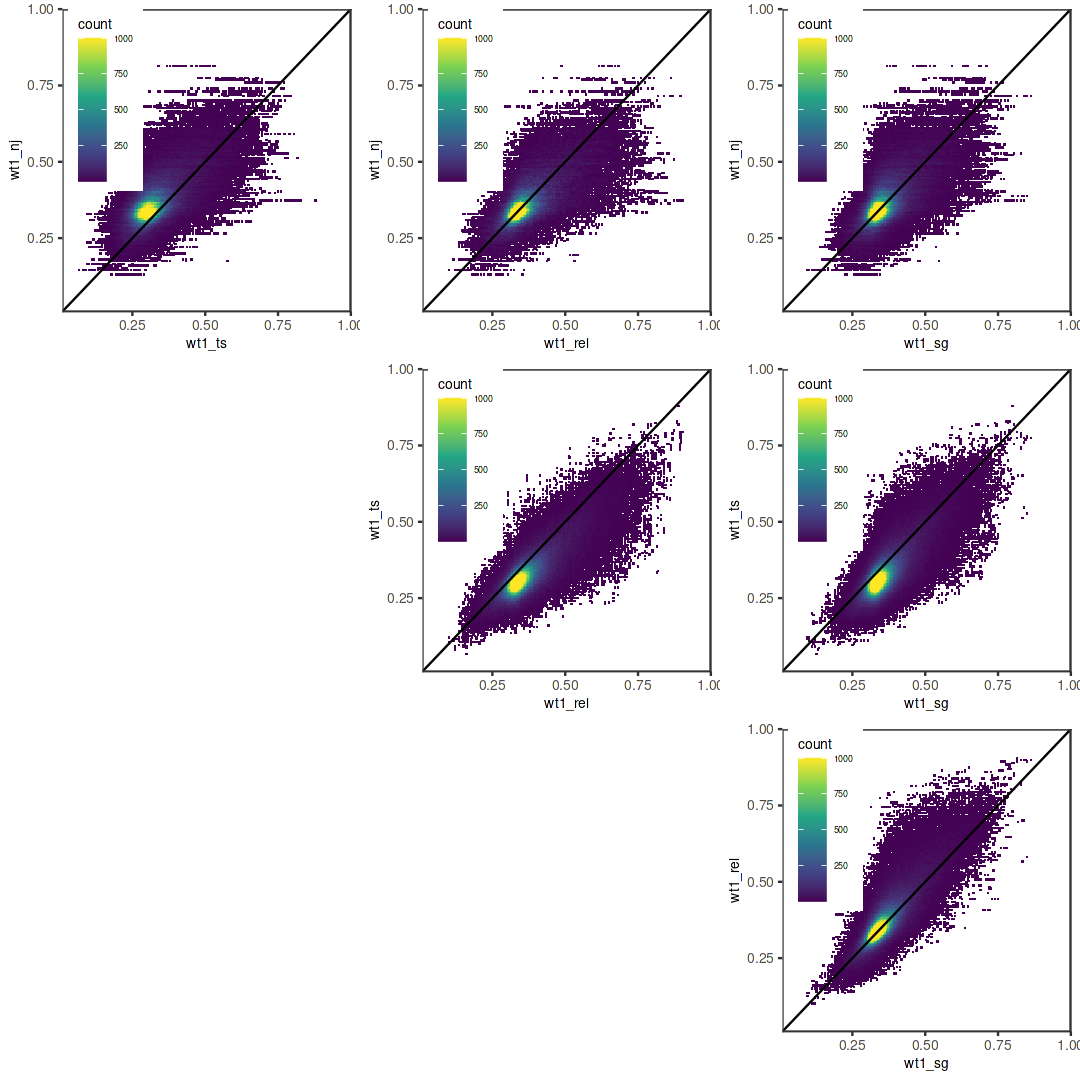

In [122]:
plt_wt1 = grid.arrange(biplot_weights(wt, "wt1_ts", "wt1_nj", c(0.01,1)),
             biplot_weights(wt, "wt1_rel", "wt1_nj", c(0.01,1)), 
             biplot_weights(wt, "wt1_sg", "wt1_nj", c(0.01,1)),

             blank_plot, 
             biplot_weights(wt, "wt1_rel", "wt1_ts", c(0.01,1)),
             biplot_weights(wt, "wt1_sg", "wt1_ts", c(0.01,1)),

             blank_plot,
             blank_plot,
             biplot_weights(wt, "wt1_sg", "wt1_rel", c(0.01,1)))
ggsave(plt_wt1, filename='../_figures/cor_wt1_mm.pdf', width=169, height=169, units='mm')